In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluating metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import gc

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/final-dataset/target.csv
/kaggle/input/final-dataset/train.csv
/kaggle/input/final-dataset/test.csv
/kaggle/input/log1/scikitlearn/default/1/Logistic Regression_model_fold_3.joblib
/kaggle/input/another-final-full-bureau-col/train.csv
/kaggle/input/another-final-full-bureau-col/test.csv


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
train =pd.read_csv('/kaggle/input/another-final-full-bureau-col/train.csv')

In [7]:
test=pd.read_csv('/kaggle/input/another-final-full-bureau-col/test.csv')

In [8]:
target=pd.read_csv('/kaggle/input/final-dataset/target.csv')

In [9]:
train.shape

(246009, 807)

In [10]:
sk_id_curr=test.SK_ID_CURR.astype(int).tolist()

In [11]:
test.drop(columns='SK_ID_CURR', inplace=True)

In [12]:
#test=test.drop(columns='Unnamed: 0')
#train=train.drop(columns='Unnamed: 0')

In [13]:
test.shape

(61502, 807)

In [14]:
def reduce_mem_usage(dataframe, verbose=True):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)
    if verbose:
        m_end = dataframe.memory_usage().sum() / 1024 ** 2
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            m_end, 100 * (m_start - m_end) / m_start))

    return dataframe

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
target = reduce_mem_usage(target)

Mem. usage decreased to 492.69 Mb (67.5% reduction)
Mem. usage decreased to 122.35 Mb (67.7% reduction)
Mem. usage decreased to  0.23 Mb (87.5% reduction)


In [15]:
class_weights = {0: 1, 1: 9}

simple_estimators = {'Logistic Regression':LogisticRegression(),
                     'Decision Tree':DecisionTreeClassifier()}

In [16]:
from sklearn.model_selection import StratifiedKFold
import joblib

def training_simple_models_kfold(estimators, class_weights, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in estimators.items():
        print("Running " + name)

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            print(f"Fold {fold + 1}/{n_splits}")
            
            # Chia dữ liệu theo fold
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


            # Chuẩn hóa dữ liệu
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Tạo model mới với class_weight
            model_instance = type(model)(class_weight=class_weights)
            
            # Huấn luyện model
            model_instance.fit(X_train_scaled, y_train)

            # Dự đoán và tính ROC AUC
            y_pred = model_instance.predict_proba(X_test_scaled)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred)
            print(f"ROC AUC for fold {fold + 1}: {roc_auc}")

            model_filename = f"{name}_model_fold_{fold + 1}.joblib"
            joblib.dump(model_instance, model_filename)
            print(f"Saved model for {name} fold {fold + 1} to {model_filename}")

        print(f"Completed {name}")
        print('*' * 20)
# Gọi hàm với k-fold
training_simple_models_kfold(simple_estimators, class_weights, train, target, n_splits=5)

Running Logistic Regression
Fold 1/5
ROC AUC for fold 1: 0.7783932373006441
Saved model for Logistic Regression fold 1 to Logistic Regression_model_fold_1.joblib
Fold 2/5
ROC AUC for fold 2: 0.7759559388259892
Saved model for Logistic Regression fold 2 to Logistic Regression_model_fold_2.joblib
Fold 3/5
ROC AUC for fold 3: 0.786094703545066
Saved model for Logistic Regression fold 3 to Logistic Regression_model_fold_3.joblib
Fold 4/5
ROC AUC for fold 4: 0.7808656153522203
Saved model for Logistic Regression fold 4 to Logistic Regression_model_fold_4.joblib
Fold 5/5
ROC AUC for fold 5: 0.7829698728982912
Saved model for Logistic Regression fold 5 to Logistic Regression_model_fold_5.joblib
Completed Logistic Regression
********************
Running Decision Tree
Fold 1/5
ROC AUC for fold 1: 0.5387468608735835
Saved model for Decision Tree fold 1 to Decision Tree_model_fold_1.joblib
Fold 2/5
ROC AUC for fold 2: 0.5439220268740789
Saved model for Decision Tree fold 2 to Decision Tree_model_

We observe that for all folds, ROC AUC for Logistic Regression has higher average score. Therefore we will choose Logistic Regression to do hyperparameter tuning.

## submit using simple model

In [20]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

a = skf.split(train, target)
for fold, (train_idx, test_idx) in enumerate(a):
    print(f"Fold {fold + 1}/5")
    if fold==2:
        X_train, X_test = train.iloc[train_idx], train.iloc[test_idx]
        y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [27]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [23]:
import joblib
from joblib import load
model_1 = load("Logistic Regression_model_fold_3.joblib")
model_2 = load("Decision Tree_model_fold_3.joblib")

In [34]:
def draw_roc_curve(model):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(test_scaled)[:, 1])
    roc_auc =roc_auc_score(y_test, model.predict_proba(test_scaled)[:, 1])
    # 6. Vẽ biểu đồ ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Model')  # Đường chéo ngẫu nhiên
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

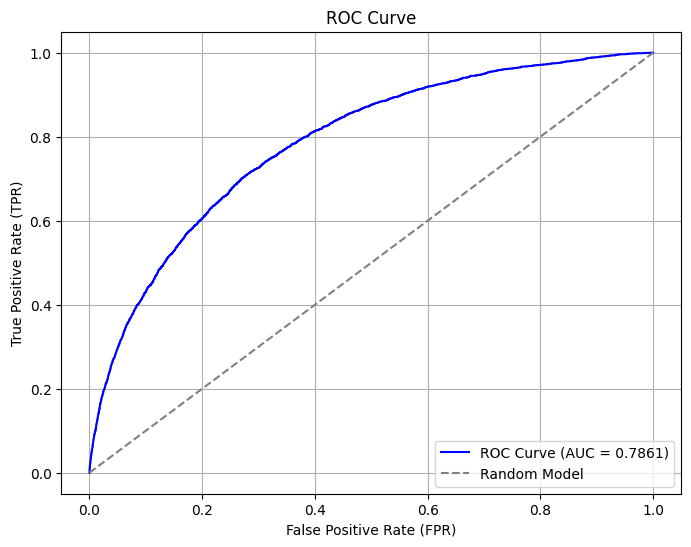

In [31]:
draw_roc_curve(model_1)

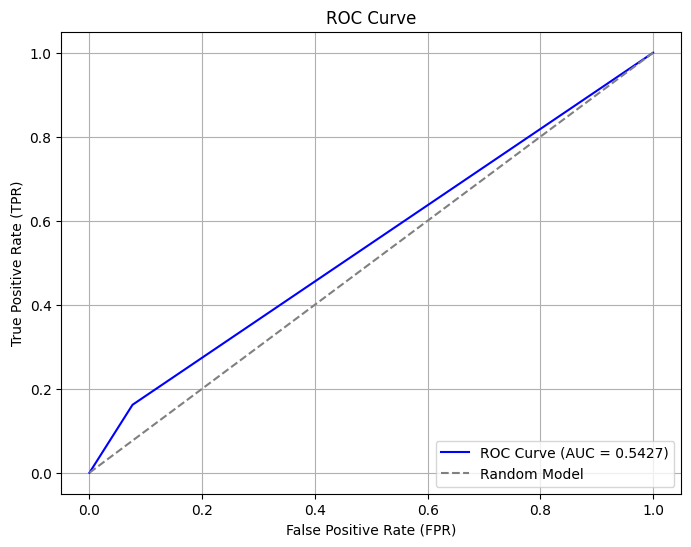

In [32]:
draw_roc_curve(model_2)

In [20]:
submission1=model_1.predict_proba(test_scaled)
submission2=model_2.predict_proba(test_scaled)

In [21]:
submit1 = pd.Series(data=submission1[:,0], index=sk_id_curr)
submit1.rename('TARGET',inplace=True)
submit1.index.name = 'SK_ID_CURR'

In [22]:
submit1.to_csv('simplemodel.csv', index=True)

In [23]:
#submit2 = pd.Series(data=submission2[:,0], index=sk_id_curr)
#submit2.rename('TARGET',inplace=True)
#submit2.index.name = 'SK_ID_CURR'

In [24]:
#submit2.to_csv('submission1.csv', index=True)

The submission with best score is simplemodel.csv from model_1 with gini=0.56167. I will extract the parameter of it to choose the search range for hyperparameter tuning

# Feature Importance

In [27]:
# Lấy hệ số hồi quy và tên các đặc trưng 
feature_importance = pd.Series(data=model_1.coef_[0],index= train.columns,name= 'coefficient')
feature_importance                    

CNT_CHILDREN                      0.010437
AMT_INCOME_TOTAL                  0.367246
AMT_CREDIT                        0.083236
AMT_ANNUITY                       0.271828
AMT_GOODS_PRICE                  -0.364130
                                    ...   
LAST_LOAN_PAID_OVER_AMOUNT_max   -0.081885
LAST_LOAN_PAID_OVER_AMOUNT_min   -0.409644
LAST_LOAN_PAID_OVER_AMOUNT_std    0.182153
LAST_LOAN_PAID_OVER_count        -0.057499
LAST_LOAN_PAID_OVER_mean         -0.109014
Name: coefficient, Length: 807, dtype: float64

In [28]:
zero_coef_features = feature_importance[abs(feature_importance)==0 ]

# In danh sách các đặc trưng này
print(f"Number of features with coefficient = 0: {len(zero_coef_features)}")
print("Features with coefficient = 0:")
print(zero_coef_features)

Number of features with coefficient = 0: 1
Features with coefficient = 0:
FLAG_MOBIL    0.0
Name: coefficient, dtype: float64


In [29]:
small_coef_features = feature_importance[abs(feature_importance) < 0.01 ]

# In danh sách các đặc trưng này
print(f"Number of features with small coefficient: {len(small_coef_features)}")
print("Features with coefficient < 0.01:")
print(small_coef_features)

Number of features with small coefficient: 43
Features with coefficient < 0.01:
FLAG_MOBIL                                             0.000000
CNT_FAM_MEMBERS                                        0.006617
FLAG_DOCUMENT_7                                       -0.007933
FLAG_DOCUMENT_12                                      -0.000534
FLAG_DOCUMENT_21                                      -0.006088
FLAG_OWN_REALTY                                       -0.008966
GROUP_ANNUITY_STD                                      0.006932
BUREAU_AMT_CREDIT_SUM_LIMIT_SUM                        0.008433
BUREAU_DAYS_CREDIT_ENDDATE_MEAN                        0.004435
BUREAU_ENDDATE_DIF_MEAN                                0.008614
BUREAU_CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN             -0.001935
BUREAU_CONSUMER_AMT_CREDIT_SUM_MEAN                    0.001983
BUREAU_CONSUMER_DEBT_CREDIT_OVERDUE_DIFF_MEAN          0.006546
BUREAU_LAST12M_DEBT_CREDIT_LIMIT_DIFF_MEAN             0.004073
CC_AMT_DRAWINGS_CURRENT_

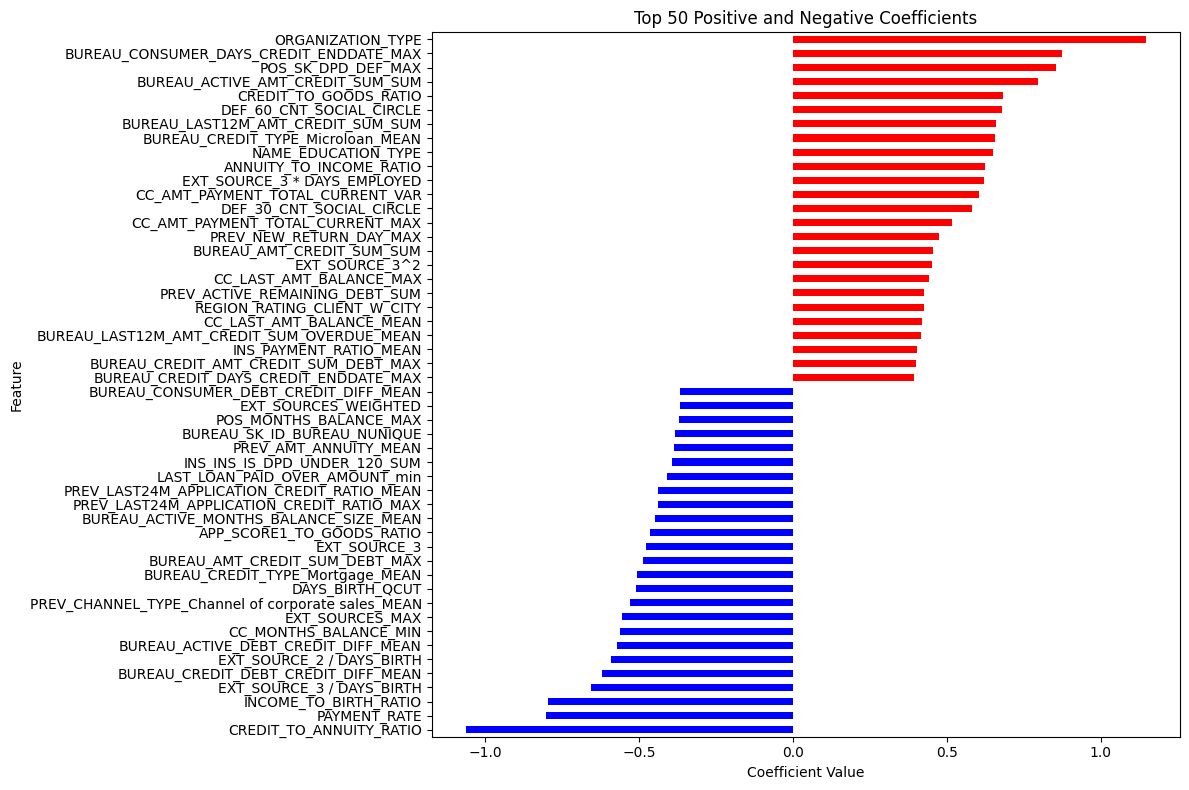

In [30]:
import matplotlib.pyplot as plt

# Lấy top 50 hệ số dương lớn nhất
top_positive_features = feature_importance.nlargest(25)

# Lấy top 50 hệ số âm nhỏ nhất
top_negative_features = feature_importance.nsmallest(25)

# Kết hợp lại hai danh sách
top_features = pd.concat([top_positive_features, top_negative_features])

# Plot biểu đồ
plt.figure(figsize=(12, 8))
top_features.sort_values().plot(kind='barh', color=['red' if x < 0 else 'blue' for x in top_features])

plt.title('Top 50 Positive and Negative Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [31]:
existing_params = model_1.get_params()
print("Loaded Model Parameters:", existing_params)

Loaded Model Parameters: {'C': 1.0, 'class_weight': {0: 1, 1: 9}, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
